# Imports

In [789]:
%matplotlib inline

import json
import math
import time
import pytz
import datetime
import cPickle as pickle

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, AutoEncoder
from keras.regularizers import l2
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from keras.layers.noise import GaussianDropout

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt

# Utilities

In [790]:
def timestamp():
    return int((datetime.datetime.now(tz=pytz.utc) - datetime.datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds())

# Data

In [791]:
f = open('output_physical.pkl', 'rb')
(X_train, Y_train), (X_test, Y_test) = pickle.load(f)
f.close()

X_train = np.array(X_train).astype("float32")
Y_train = np.array(Y_train).astype("float32")
X_test = np.array(X_test).astype("float32")
Y_test = np.array(Y_test).astype("float32")

In [792]:
joint_count = 7
joint_stride = joint_count * 3 # x, y, z

In [793]:
def get_X_max(X, joint_stride):
    joint_positions = X[:,:joint_stride*1]
    joint_rotations = X[:,joint_stride*1:joint_stride*2]
    linear_velocities = X[:,joint_stride*2:joint_stride*3]
    angular_velocities = X[:,joint_stride*3:joint_stride*4]
    target_directions = X[:,joint_stride*4:joint_stride*5]
    target_rotations = X[:,joint_stride*5:]

    joint_position_max = np.fabs(joint_positions).max()
    joint_rotation_max = np.fabs(joint_rotations).max()
    linear_velocity_max = np.fabs(linear_velocities).max()
    angular_velocity_max = np.fabs(angular_velocities).max()
    target_direction_max = np.fabs(target_directions).max()
    target_rotation_max = np.fabs(target_rotations).max()
    
    print(joint_position_max, joint_rotation_max, linear_velocity_max, angular_velocity_max, target_direction_max, target_rotation_max)

    return np.hstack([
        np.repeat(joint_position_max, joint_stride),
        np.repeat(joint_rotation_max, joint_stride),
        np.repeat(linear_velocity_max, joint_stride),
        np.repeat(angular_velocity_max, joint_stride),
        np.repeat(target_direction_max, joint_stride),
        np.repeat(target_rotation_max, joint_stride)
    ])

In [794]:
X_max = get_X_max(X_train, joint_stride)
Y_max = np.fabs(Y_train).max()
print 'X_max', json.dumps(X_max.tolist())
print 'Y_max', Y_max

(96.330177, 180.0, 319.69812, 50.487072, 5.9325485, 179.99969)
X_max [96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 96.3301773071289, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 319.6981201171875, 50.487

In [795]:
X_train_norm = X_train / X_max
Y_train_norm = Y_train / Y_max
X_test_norm = X_test / X_max
Y_test_norm = Y_test / Y_max

In [796]:
print(X_train_norm.shape, Y_train_norm.shape, 'train samples')
print(X_test_norm.shape, Y_test_norm.shape, 'test samples')

((310000, 126), (310000, 6), 'train samples')
((31000, 126), (31000, 6), 'test samples')


# Model

In [797]:
model = Sequential()
model.add(Dense(input_dim=126, output_dim=128, activation='relu', init='normal'))
model.add(Dropout(0.5))
model.add(Dense(input_dim=128, output_dim=128, activation='relu', init='normal'))
model.add(Dropout(0.5))
model.add(Dense(input_dim=128, output_dim=6, init='normal'))

# Fit

In [798]:
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='rmsprop')

In [799]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
batch_size = 100
nb_epoch = 20
validation_split = 0.1
shuffle = True

history = model.fit(X_train_norm, Y_train_norm, \
                    nb_epoch=nb_epoch, batch_size=batch_size, \
                    shuffle=shuffle, validation_split=validation_split, \
                    callbacks=[early_stopping])

Train on 279000 samples, validate on 31000 samples
Epoch 1/20
279000/279000 [==============================] - 10s - loss: 0.1598 - val_loss: 0.1112
Epoch 2/20
279000/279000 [==============================] - 12s - loss: 0.0887 - val_loss: 0.0516
Epoch 3/20
279000/279000 [==============================] - 12s - loss: 0.0671 - val_loss: 0.0453
Epoch 4/20
279000/279000 [==============================] - 11s - loss: 0.0620 - val_loss: 0.0410
Epoch 5/20
279000/279000 [==============================] - 13s - loss: 0.0593 - val_loss: 0.0399
Epoch 6/20
279000/279000 [==============================] - 12s - loss: 0.0575 - val_loss: 0.0380
Epoch 7/20
279000/279000 [==============================] - 13s - loss: 0.0561 - val_loss: 0.0376
Epoch 8/20
279000/279000 [==============================] - 11s - loss: 0.0552 - val_loss: 0.0375
Epoch 9/20
279000/279000 [==============================] - 11s - loss: 0.0542 - val_loss: 0.0363
Epoch 10/20
279000/279000 [==============================] - 12s - 

# Evaluate

In [800]:
score = model.evaluate(X_test_norm, Y_test_norm)
score

31000/31000 [==============================] - 0s     


0.03306891398387149

# Save

In [801]:
model_json = json.loads(model.to_json())
model_json["timestamp"] = str(datetime.datetime.now(tz=pytz.utc))
model_json["score"] = score

ts = timestamp()

open('model-%s.json' % ts, 'w').write(json.dumps(model_json))
model.save_weights('weights-%s.hdf5' % ts, overwrite=True)

# Loss

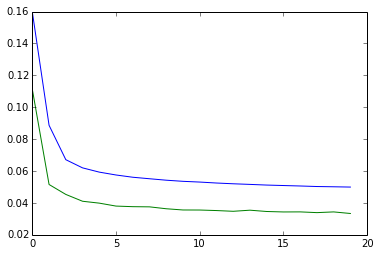

In [802]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Weights

<matplotlib.colorbar.Colorbar instance at 0x140236518>

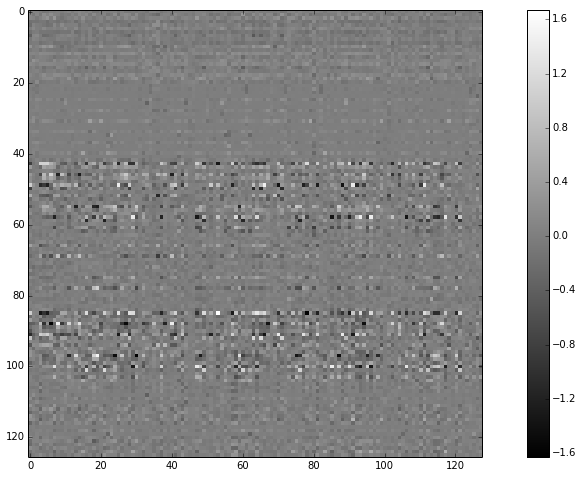

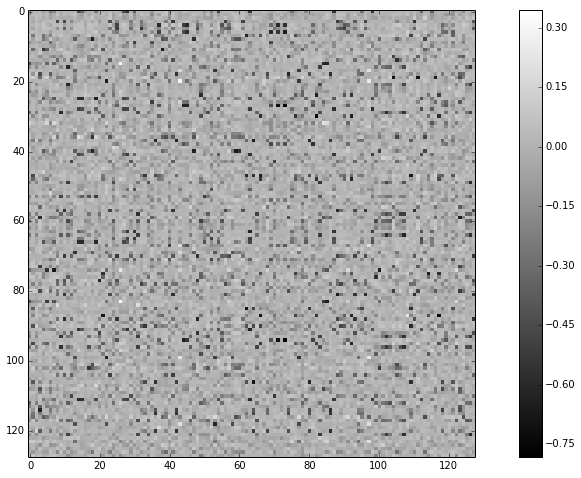

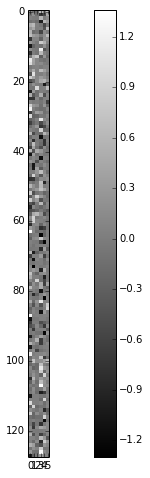

In [803]:
W = model.layers[0].W.get_value()
plt.figure(figsize=(16, 8))
plt.imshow(W, 'gray', interpolation="nearest")
plt.colorbar()

W = model.layers[2].W.get_value()
plt.figure(figsize=(16, 8))
plt.imshow(W, 'gray', interpolation="nearest")
plt.colorbar()

W = model.layers[4].W.get_value()
plt.figure(figsize=(16, 8))
plt.imshow(W, 'gray', interpolation="nearest")
plt.colorbar()